In [2]:
import tensorflow as tf 
#from tensorflow.python.client import device_lib
#print(device_lib.listlocal_devices())

In [3]:
from keras import backend as K
import keras.utils.np_utils

from keras.models import Sequential
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, ZeroPadding1D
from keras.applications.vgg16 import VGG16

from keras. preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import Adadelta
from keras.optimizers import Nadam

import numpy as np
import pandas as pd

from IPython.display import SVG
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import sys
from IPython.display import display 
from keras.utils.training_utils import multi_gpu_model


#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1/255, 
    horizontal_flip=True, 
    width_shift_range=.2, 
    height_shift_range=.2, 
    zoom_range =0.2, 
    fill_mode= 'nearest'
)

In [5]:
def plot_images(x, y, **kwargs):
    n_pix = int(np.sqrt(np.prod(x.shape[1:3]))) #assumes images are square
    im_indices = np.random.choice(x.shape[0], 36, replace=False)
    fig, axes = subplots(nrows=6,ncols=6, figsize=(10,10), sharex=True, sharey=True, frameon=False)
    for i,ax in enumerate(axes.flat):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        curr_i = im_indices[i]
#         curr_label = label[argmax(y[curr_i])]
        ax.imshow(x[curr_i].reshape(n_pix,n_pix, 3), aspect="auto", **kwargs)
        ax.text(10,20,y[curr_i], fontdict={"backgroundcolor": "gray","color": "white" })
#         ax.set_title(title)
        ax.axis('off')
    plt.tight_layout(h_pad=0, w_pad=0)

In [6]:
%pylab inline
IMSIZE = [100, 100]
BATCH  =  40

train_gentrain_g  = datagen.flow_from_directory(class_mode='sparse',
    directory='images/adience/test_train_adience/train',
    target_size=IMSIZE,
    batch_size=BATCH,
)

val_gen = datagen.flow_from_directory(class_mode='sparse',
    directory='images/adience/test_train_adience/test',
    target_size=IMSIZE,
    batch_size=BATCH,
)
x,y = next(train_gentrain_g)

Populating the interactive namespace from numpy and matplotlib
Found 6599 images belonging to 24 classes.
Found 2810 images belonging to 25 classes.


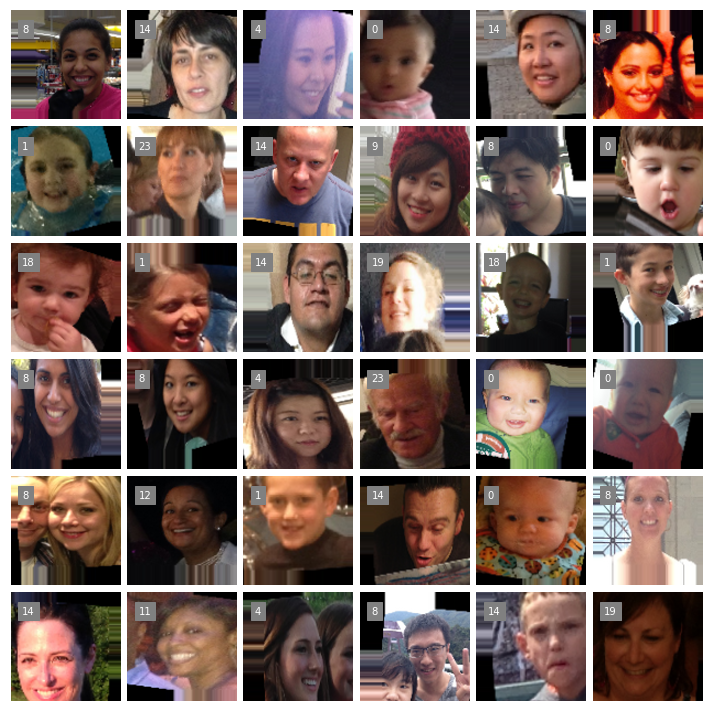

In [7]:
plot_images(x, y, interpolation="spline16")

In [18]:
print(x.shape)

(40, 100, 100, 3)


In [19]:
x.shape[1:]

(100, 100, 3)

In [20]:
my_model = Sequential()
my_model.add(Conv2D(16, (3, 3), padding='same',
                 input_shape=x.shape[1:]))
my_model.add(Activation('relu'))
my_model.add(Conv2D(16, (3, 3)))
my_model.add(Activation('relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2)))
my_model.add(Dropout(0.1))

my_model.add(Conv2D(16, (3, 3), padding='same'))
my_model.add(Activation('relu'))
my_model.add(Conv2D(16, (3, 3)))
my_model.add(Activation('relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2)))
my_model.add(Dropout(0.1))

# added layers start
my_model.add(Conv2D(16, (3, 3), padding='same'))
my_model.add(Activation('relu'))
my_model.add(Conv2D(16, (3, 3)))
my_model.add(Activation('relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2)))
my_model.add(Dropout(0.1))
# added layers end

my_model.add(Flatten())
my_model.add(Dense(512))
my_model.add(Activation('relu'))
my_model.add(Dropout(0.3))
my_model.add(Dense(1))
my_model.add(Activation('linear'))

# decreased dropout rate


In [14]:
#x,y = next(train_gentrain_g)

#Get back the convolutional part of a VGG network trained on ImageNet
#model_vgg16_conv = VGG16(weights='imagenet',pooling='avg', include_top=False)


#model_vgg16_conv.summary()

# Tailor our input format (Note- Tensorflow input order!)
#input = Input(shape=x.shape[1:],name = 'image_input')  # our input shape: (32,32,3)

#Use the generated model 
# output_vgg16_conv = model_vgg16_conv(input)

# #Add the fully-connected layers 
# #x = Flatten(name='flatten')
# x = Dense(100, activation='relu', name='fc1')(output_vgg16_conv)
# x = Dense(50, activation='relu', name='fc2')(x)
# x = Dense(1, activation='linear', name='predictions')(x)

# #Create your own model 
# my_model = Model(input=input, output=x)  # Using the Functional API
# # Freeze convolutional layers
# for layer in my_model.layers[:2]:
#     layer.trainable=False

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
#Omodel.summary(line_length=150)

In [21]:
# must use a very small learning rate 
# sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

#my_model.compile(optimizer='nadam', loss='mean_squared_error', metrics = ['mae'])

#keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# tried 1.
# tried .1
# .01 works well
# .001 works well

with tf.device('/cpu:0'):
    Omodel = my_model
my_model = multi_gpu_model(Omodel, gpus=8)

# my_model.compile(optimizer=Adam(lr=.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), loss='mean_squared_error')
# my_model.compile(optimizer=Adadelta(), loss='mean_squared_error')
my_model.compile(optimizer=Nadam(), loss='mean_squared_error')
Omodel.summary(line_length=150)

______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
conv2d_7 (Conv2D)                                                  (None, 100, 100, 16)                                        448                    
______________________________________________________________________________________________________________________________________________________
activation_9 (Activation)                                          (None, 100, 100, 16)                                        0                      
______________________________________________________________________________________________________________________________________________________
conv2d_8 (Conv2D)                                                  (None, 98, 98, 16)         

In [16]:
# # prepare data augmentation configuration 
# test_steps = val_gen.n//val_gen.batch_size
# train_steps = train_gentrain_g.n//train_gentrain_g.batch_size

# # same callbacks!
# cb_a=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
# # lets look at our results while we are at it
# cb_b=keras.callbacks.ReduceLROnPlateau(factor=.5, patience=2, min_lr=1e-8)
# #cb_c = keras.callbacks.ModelCheckpoint('/home/ubuntu/project_pi/model/weights.hdf5', monitor='mean_squared_error', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# # fine-tune the model
# history = my_model.fit_generator(
#     train_gentrain_g,
#     steps_per_epoch= train_steps,
#     nb_epoch=100,
#     validation_data=val_gen,
#     validation_steps=test_steps,
#     callbacks=[cb_b, cb_a])
# my_model.save('tuesday1.h5')

In [ ]:
# prepare data augmentation configuration 
test_steps = val_gen.n//val_gen.batch_size
train_steps = train_gentrain_g.n//train_gentrain_g.batch_size

# same callbacks!
cb_a=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
# lets look at our results while we are at it
cb_b=keras.callbacks.ReduceLROnPlateau(factor=.5, patience=2, min_lr=1e-8)
#cb_c = keras.callbacks.ModelCheckpoint('/home/ubuntu/project_pi/model/weights.hdf5', monitor='mean_squared_error', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

my_model.load_weights('tuesday2_1.h5')

# fine-tune the model
for i in range(20):
    history = my_model.fit_generator(
        train_gentrain_g,
        steps_per_epoch= train_steps,
        nb_epoch=1,
        validation_data=val_gen,
        validation_steps=test_steps,
        callbacks=[cb_b, cb_a])
    my_model.save_weights(f'tuesday3_{i}.h5')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=3738, validation_data=<keras_pre..., validation_steps=1600, callbacks=[<keras.ca..., epochs=1)`


Epoch 1/1
3738/3738 [==============================] - 925s 247ms/step - loss: 217.8032 - val_loss: 213.6161
Epoch 1/1
3738/3738 [==============================] - 924s 247ms/step - loss: 217.0047 - val_loss: 211.9199
Epoch 1/1
3738/3738 [==============================] - 922s 247ms/step - loss: 216.5291 - val_loss: 211.7933
Epoch 1/1
3738/3738 [==============================] - 923s 247ms/step - loss: 215.8800 - val_loss: 213.2884
Epoch 1/1
1514/3738 [===========>..................] - ETA: 6:24 - loss: 215.5460

In [14]:
# my_model.save_weights('tuesday1_0.h5')

In [ ]:
from keras.models import load_model

model = load_model('monday.h5')

In [ ]:
history.history

In [ ]:
predictions  = model.predict_generator(val_gen)

In [ ]:
val_gen.classes

In [ ]:
predictions

In [ ]:
error = predictions - val_gen.classes

In [ ]:
np.mean(error**2)

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(history_dict['acc']) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
plt.clf()
acc_values = history_dict['acc'] 
val_acc_values = history_dict['val_acc']
plt.plot(epochs, history_dict['acc'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()